**In this notebook you can find the code for experiments with ML models**

### Import libraries and download the data

In [1]:
!pip install -q catboost
import catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.6 MB/s eta 0:00:00


In [30]:
!pip install -q shap
import shap

In [2]:
!pip install --quiet optuna
import optuna
from optuna.samplers import TPESampler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import os
import torch
from scipy import stats

from astropy.time import Time
from tqdm import tqdm
from IPython.display import clear_output

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

import xgboost
from sklearn.model_selection import cross_val_score, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import QuantileTransformer

In [4]:
#Download data for J0332
!gdown -O J0332_train.csv 1iQ13yJqX8c9_hQTUBBLHbuG9IdZM1ToT #train
!gdown -O J0332_test.csv 1_jp0DLCDZUo7KxhQzTzBVeF_T7wezYoZ #test
!gdown -O J0332_val.csv 1AEdoNwNkgfIjvWlpQQ8cI876yEjOwgZE #val
!gdown 1N4VPXnAfbKECKf6qRCHUpkmf5kP_epco #trend params

clear_output()

In [5]:
header = ['X-ray B',	'SYM-H',	'F10.7',	'LST',	'SML',	'SMU',	'SMR', 'time', 'RM_real', 'RM_real_stat', 'VTEC', 'Bpar', 'z', 'target1', 'target2', 'target3']

train = pd.read_csv("J0332_train.csv", sep=' ', names=header)
val = pd.read_csv("J0332_val.csv", sep=' ', names=header)
test = pd.read_csv("J0332_test.csv", sep=' ', names=header)

In [7]:
shuffled_train = train.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
x_train = shuffled_train[['X-ray B',	'SYM-H',	'F10.7',	'LST',	'SML',	'SMU',	'SMR']]
x_val = val[['X-ray B',	'SYM-H',	'F10.7',	'LST',	'SML',	'SMU',	'SMR']]
x_test = test[['X-ray B',	'SYM-H',	'F10.7',	'LST',	'SML',	'SMU',	'SMR']]

y_train = shuffled_train[["target1"]]
y_val = val[["target1"]]
y_test = test[["target1"]]

Here we define a function with our metrics

In [6]:
def get_quality(y_test, y_pred, dataset, show_stat = False):
    rm_recovered  = dataset["Bpar"].to_numpy() * dataset["VTEC"].to_numpy() * 2.62e-6 / (y_pred)**0.5
    rm_real = dataset["RM_real"].to_numpy()
    time = dataset["time"].to_numpy()

    residual = rm_recovered - rm_real
    mae = mean_absolute_error(rm_real, rm_recovered)
    print("Mean absolute error between series:", mae)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(time, rm_recovered, color='blue', label='recovered')
    axs[0].plot(time, rm_real, color='red', label='real')
    axs[0].set_title('Real vs recovered')
    axs[0].legend()

    axs[1].plot(time, residual, color='black')
    axs[1].set_title('Residual')

    plt.tight_layout()
    plt.show()

    if show_stat:
        #Kolmogorov-Smirnov test
        statistic, p_value = stats.kstest(residual, 'norm')

        print(f"KS statistic: {statistic}")
        print(f"P-value: {p_value}")

        alpha = 0.05
        if p_value < alpha:
            print("We reject the null hypothesis: the data are not normal.")
        else:
            print("We do not reject the null hypothesis: the data may be normal.")

        plt.figure(figsize=(10, 5))
        plt.hist(residual, bins=30, density=True, alpha=0.6, color='g', label='Histogram')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, np.mean(residual), np.std(residual))
        plt.plot(x, p, 'k', linewidth=2, label='Normal distribution')
        plt.title('Data histogram and normal distribution')
        plt.legend()
        plt.show()

        #observe the power spectrum
        n = len(residual)
        frequencies = np.fft.fftfreq(n, d=np.mean(np.diff(time)))
        fft_values = np.fft.fft(residual)  # fourier transform
        power_spectrum = np.abs(fft_values)**2 / n

        positive_frequencies = frequencies[:n // 2]
        positive_power_spectrum = power_spectrum[:n // 2]

        plt.figure(figsize=(12, 6))
        plt.plot(positive_frequencies, positive_power_spectrum)
        plt.title('Power spectrum of residuals')
        plt.yscale("log")
        plt.xscale("log")
        plt.grid()
        plt.show()

### SLM

Let's test standart single layer model of ionosphere

In [12]:
R = 6371.
test_SLM = test['Bpar']*test['VTEC']*2.62e-6/(1 - (R*np.sin(test['z'])/(R+450))**2)**0.5

Mean absolute error between series: 0.05580303086247731


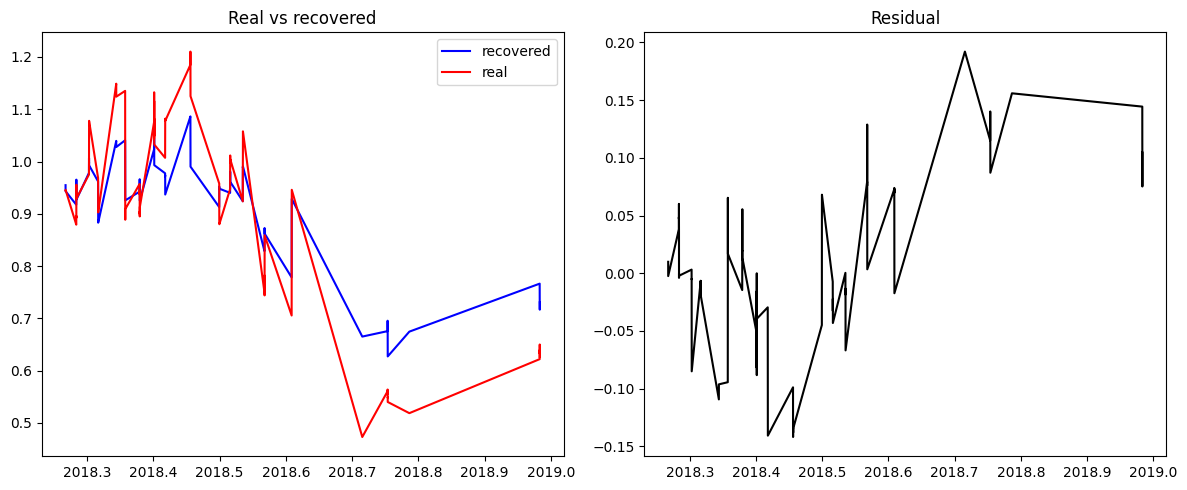

KS statistic: 0.4435642704761803
P-value: 9.4831719547698e-23
We reject the null hypothesis: the data are not normal.


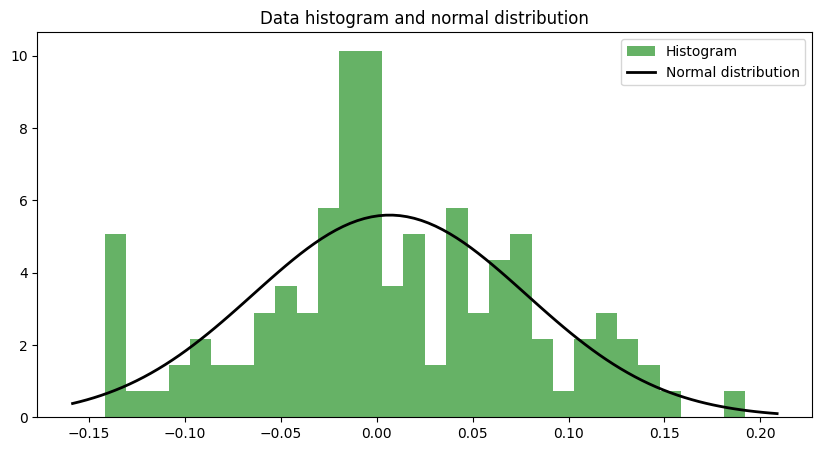

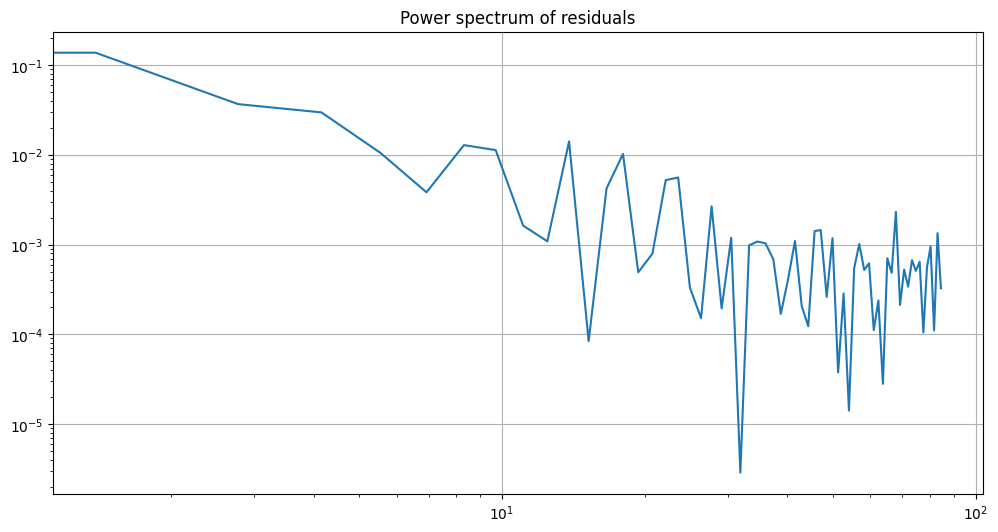

In [13]:
get_quality(y_test, test_SLM, test, show_stat=True)

### Ridge

Linear model with L2 regularization

In [14]:
ridge = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(ridge, param_grid, cv=5)
grid_search.fit(x_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 10


In [15]:
model = Ridge(best_alpha)
model.fit(x_train, y_train)
y_pred = np.ravel(model.predict(x_test))

In [16]:
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 0.009792059682345181


Mean absolute error between series: 0.0401148773081084


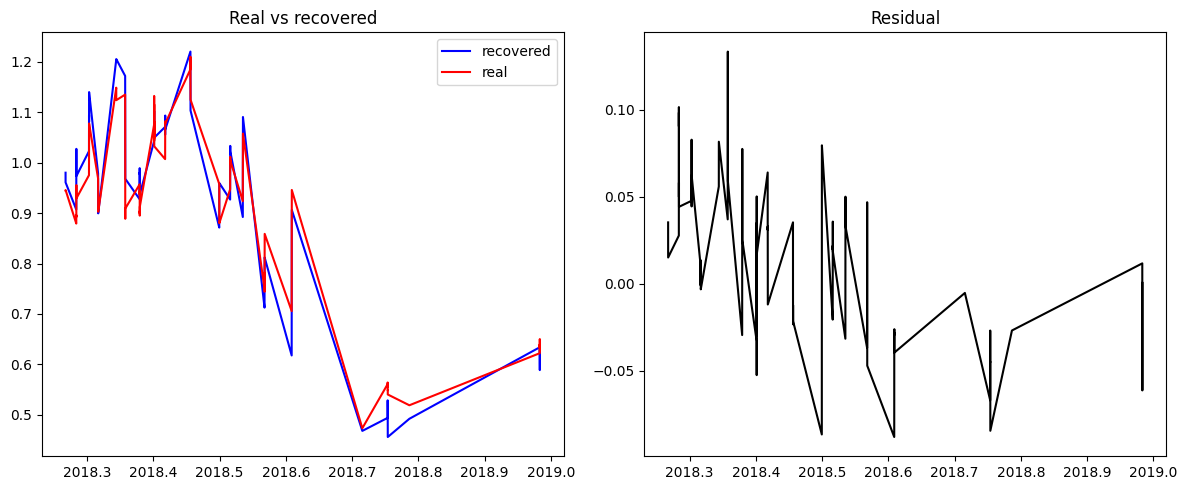

In [17]:
get_quality(y_test, y_pred, test)

### Lasso

Linear model with L1 regularization

In [18]:
lasso = Lasso()
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(x_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 0.0001


In [19]:
model = Lasso(best_alpha)
model.fit(x_train, y_train)
y_pred = np.ravel(model.predict(x_test))

In [20]:
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 0.009786358915877973


Mean absolute error between series: 0.04026781093256023


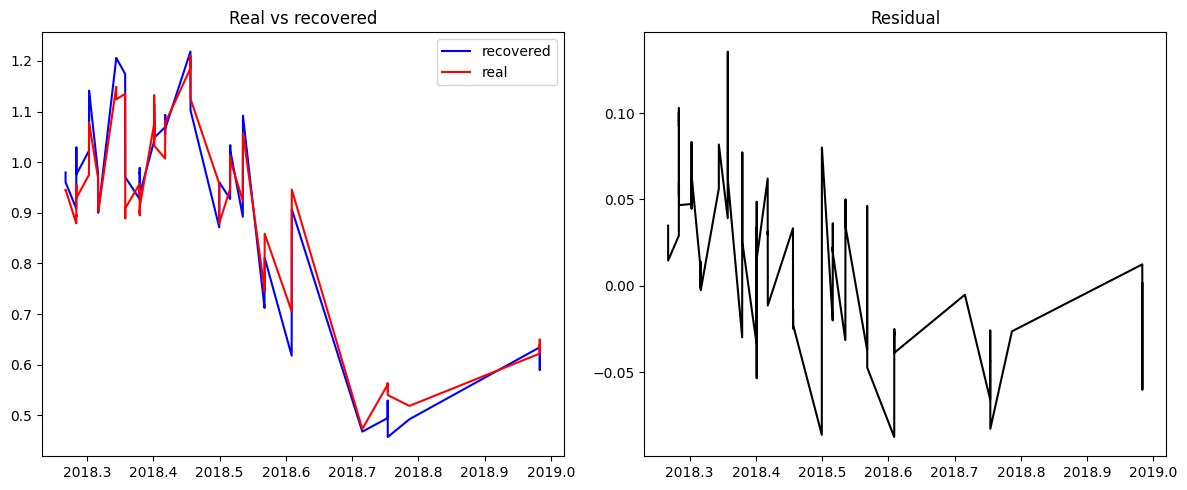

In [21]:
get_quality(y_test, y_pred, test)

Let's look at the weights of the model to get the features importance

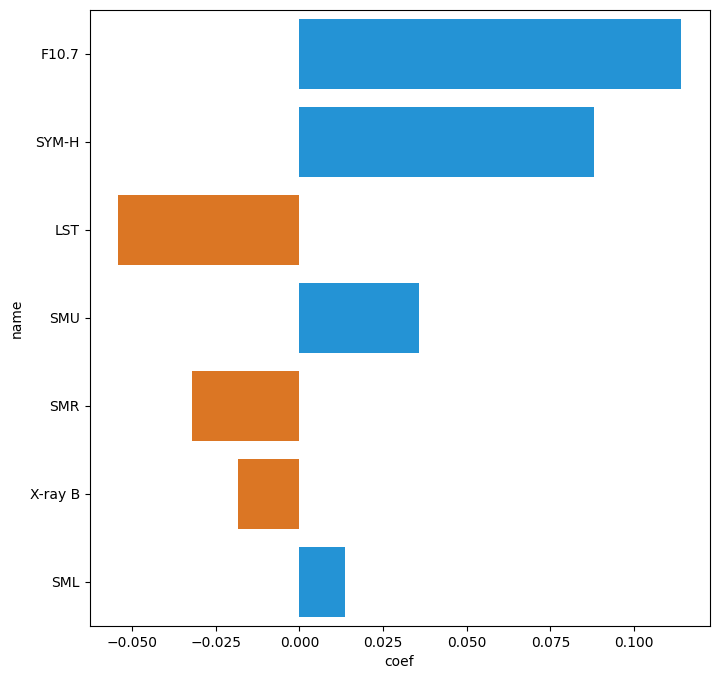

In [22]:
importance = model.coef_
df_temp = pd.DataFrame({"name": x_train.columns, "coef": importance}).sort_values(
    "coef", key=abs, ascending=False
)

df_temp["sign"] = ["neg" if x < 0 else "pos" for x in df_temp["coef"]]

palette = {"neg": sns.xkcd_rgb["orange"], "pos": sns.xkcd_rgb["azure"]}

plt.figure(figsize=(8, 8))
sns.barplot(
    data=df_temp,
    y="name",
    x="coef",
    hue="sign",
    palette=palette,
    legend=False,
    orient="h",
)
plt.show()

### SVR

Support vector regression model

In [23]:
def objective(trial):
    # boundaries for the optimizer's
    C_suggested = trial.suggest_float("C", 0., 7.)
    epsilon_suggested = trial.suggest_float("epsilon", 1e-4, 1)

    # create new model(and all parameters) every iteration
    model = SVR(
        C = C_suggested,
        epsilon = epsilon_suggested,
    )
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    neg_mse = cross_val_score(
        model, x_train, np.ravel(y_train), cv=kf, scoring="neg_mean_squared_error"
    ).mean()
    error = -neg_mse

    return error


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=TPESampler(42)
)

study.optimize(
    objective, n_trials=7
)

[I 2024-11-26 21:58:01,511] A new study created in memory with name: Optimizer
[I 2024-11-26 21:58:01,555] Trial 0 finished with value: 0.028523900181734296 and parameters: {'C': 0.7070364057530016, 'epsilon': 0.6601088574205909}. Best is trial 0 with value: 0.028523900181734296.
[I 2024-11-26 21:58:01,594] Trial 1 finished with value: 0.02321652909741835 and parameters: {'C': 1.2060676250039535, 'epsilon': 0.32516294694766207}. Best is trial 1 with value: 0.02321652909741835.
[I 2024-11-26 21:58:01,636] Trial 2 finished with value: 0.028523900181734296 and parameters: {'C': 5.834092654740222, 'epsilon': 0.8255968436925318}. Best is trial 1 with value: 0.02321652909741835.
[I 2024-11-26 21:58:01,671] Trial 3 finished with value: 0.028523900181734296 and parameters: {'C': 5.498441799624587, 'epsilon': 0.46334774224379593}. Best is trial 1 with value: 0.02321652909741835.
[I 2024-11-26 21:58:01,700] Trial 4 finished with value: 0.028523900181734296 and parameters: {'C': 2.572558712216096

In [24]:
optuna.visualization.plot_optimization_history(study)

In [25]:
model = SVR(C=study.best_params['C'], epsilon=study.best_params['epsilon'])

y_train = np.ravel(y_train)
model.fit(x_train, y_train)
y_pred = np.ravel(model.predict(x_test))

In [26]:
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 0.013258207204046695


Mean absolute error between series: 0.05019829985788384


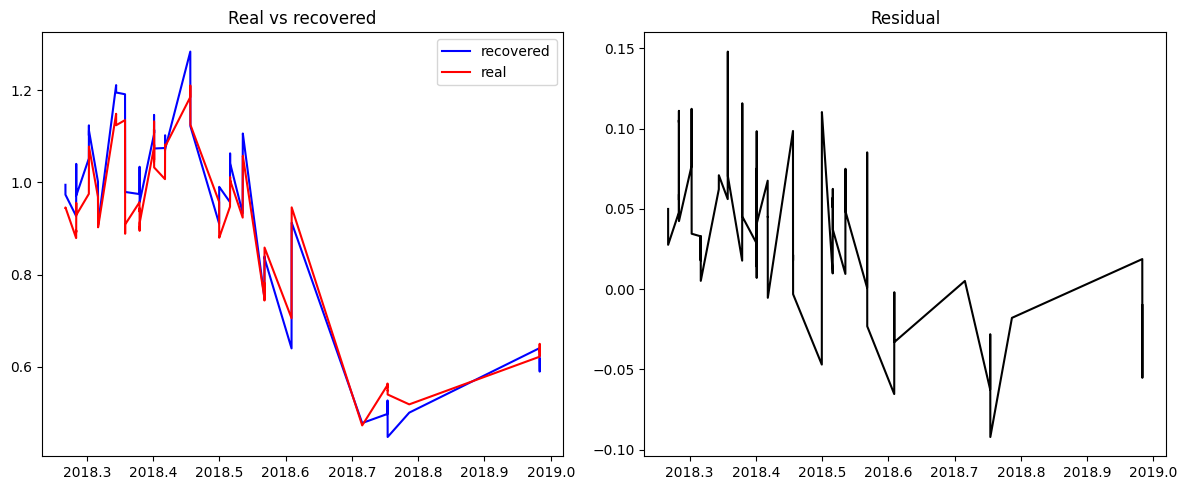

In [27]:
get_quality(y_test, y_pred, test)

### Cat Boost

Gradient boosting model

In [29]:
def objective(trial):
    # boundaries for the optimizer's
    depth = trial.suggest_int("depth", 1, 10, step=1) #начать с поменьше
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 6, 10, step=2)
    l2_leaf_reg = trial.suggest_categorical("l2_leaf_reg", [2, 5, 7, 10])
    random_strength = trial.suggest_float("random_strength", 1, 2)
    lr = trial.suggest_float("learning_rate", 0.0001, 0.1)

    # create new model(and all parameters) every iteration
    model = catboost.CatBoostRegressor(
        iterations=2000,
        learning_rate=lr,
        depth=depth,
        min_data_in_leaf=min_data_in_leaf,
        l2_leaf_reg=l2_leaf_reg,
        random_strength=random_strength,
        random_state=42,
        verbose=0,
    )
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    neg_mse = cross_val_score(
        model, x_train, np.ravel(y_train), cv=kf, scoring="neg_mean_squared_error"
    ).mean()
    error = -neg_mse

    return error


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=TPESampler(42)
)

study.optimize(
    objective, n_trials=10
)

clear_output()

In [31]:
model = catboost.CatBoostRegressor(
    iterations=2000,
    learning_rate=study.best_params["learning_rate"],
    depth=study.best_params["depth"],
    min_data_in_leaf=study.best_params["min_data_in_leaf"],
    l2_leaf_reg=study.best_params["l2_leaf_reg"],
    random_strength=study.best_params["random_strength"],
    random_state=42,
    verbose=0,
)

y_train = np.ravel(y_train)
model.fit(x_train, y_train, eval_set=(x_val, y_val))
y_pred = np.ravel(model.predict(x_test))

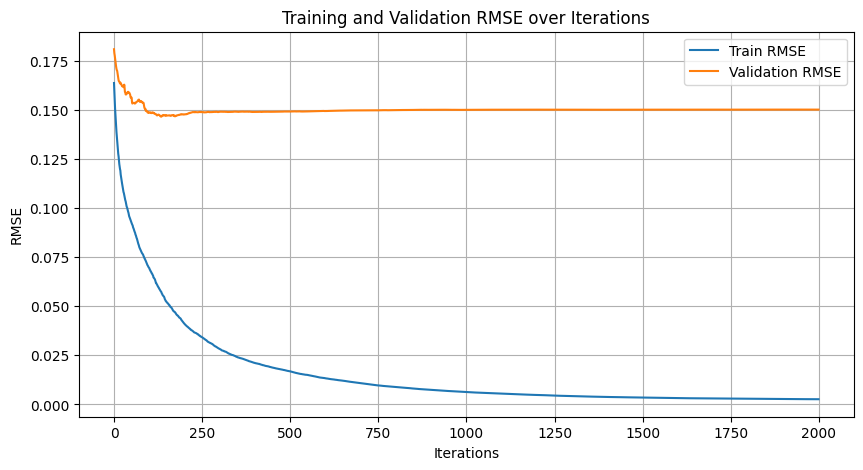

In [32]:
train_metrics = model.get_evals_result()['learn']
val_metrics = model.get_evals_result()['validation']

plt.figure(figsize=(10, 5))
plt.plot(train_metrics['RMSE'], label='Train RMSE')
plt.plot(val_metrics['RMSE'], label='Validation RMSE')
plt.title('Training and Validation RMSE over Iterations')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [33]:
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 0.009066319876868855


Mean absolute error between series: 0.03904078134681059


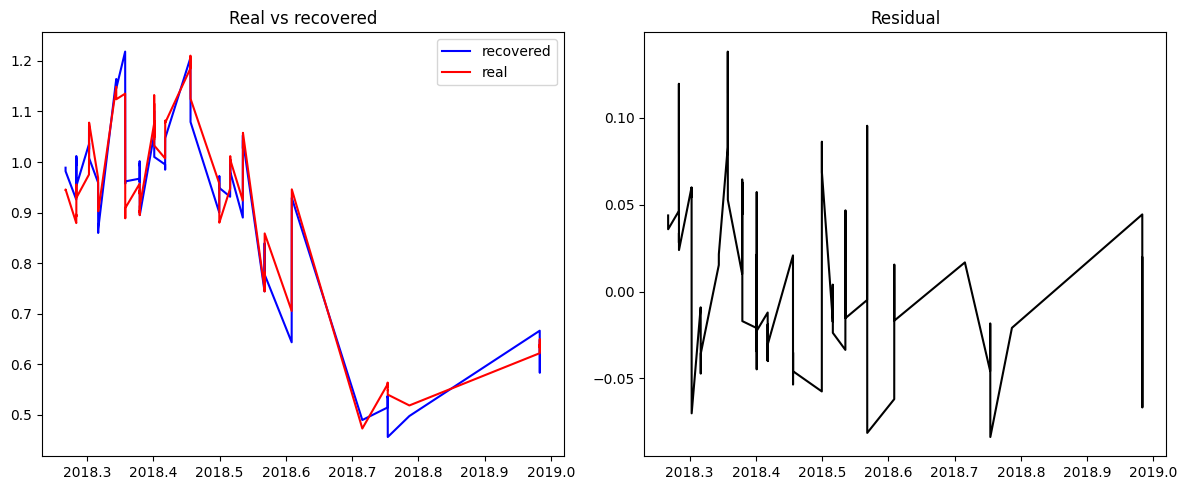

In [34]:
get_quality(y_test, y_pred, test)

### XGBoost

Gradient boosting model

In [35]:
def objective(trial):
    # boundaries for the optimizer's
    n = trial.suggest_int("n_estimators", 500, 5000, step=100)
    depth = trial.suggest_int("depth", 5, 9, step=1)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 15, step=1)

    # create new model(and all parameters) every iteration
    model = xgboost.XGBRegressor(
        n_estimators=n,
        learning_rate=lr,
        max_depth=depth,
        min_child_weight = min_child_weight,
        random_state=42,
    )
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    neg_mse = cross_val_score(
        model, x_train, np.ravel(y_train), cv=kf, scoring="neg_mean_squared_error"
    ).mean()
    error = -neg_mse

    return error


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=TPESampler(42)
)

study.optimize(
    objective, n_trials=10
)

[I 2024-11-26 22:07:47,207] A new study created in memory with name: Optimizer
[W 2024-11-26 22:07:50,562] Trial 0 failed with parameters: {'n_estimators': 1200, 'depth': 7, 'learning_rate': 0.007807302117197882, 'min_child_weight': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-35-617adaaba5ef>", line 17, in objective
    neg_mse = cross_val_score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 712, in cross_val_score
    cv_results = cross_validate(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "/usr/local

KeyboardInterrupt: 

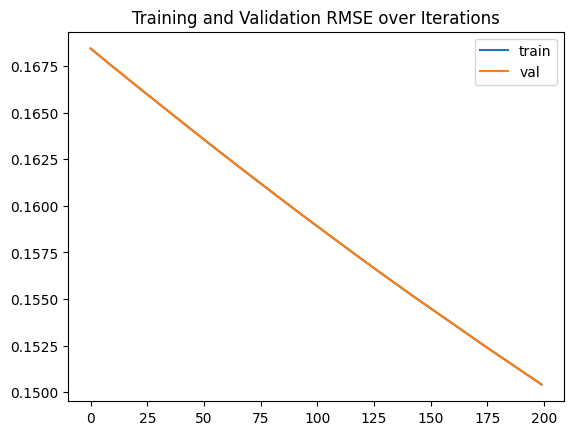

In [36]:
'''
model = xgboost.XGBRegressor(
        n_estimators=study.best_params["n_estimators"],
        learning_rate=study.best_params["learning_rate"],
        max_depth=study.best_params["depth"],
        min_child_weight = study.best_params["min_child_weight"],
        random_state=42,
    )
'''
model = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.001)
y_train = np.ravel(y_train)
eval_set = [(x_train, y_train), (x_val, y_val)]

model.fit(x_train, y_train, eval_set = eval_set, verbose=False)
y_pred = np.ravel(model.predict(x_test))

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])

plt.plot(range(0, epochs), results['validation_0']['rmse'], label='train')
plt.plot(range(0, epochs), results['validation_0']['rmse'], label='val')
plt.title('Training and Validation RMSE over Iterations')
plt.legend()
plt.show()

In [37]:
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 0.009434002204176303


Mean absolute error between series: 0.03164085192929372


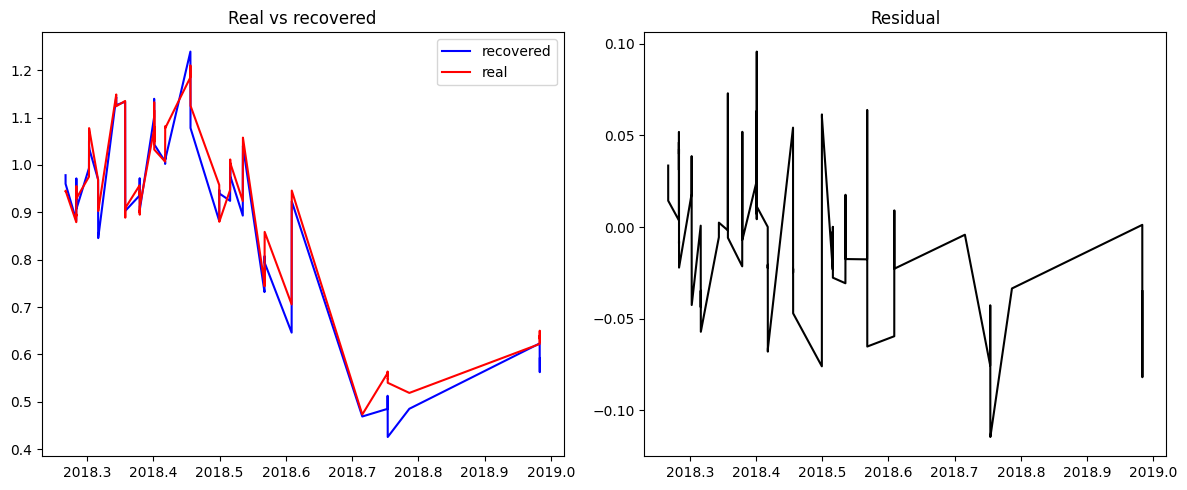

KS statistic: 0.46286510431064065
P-value: 7.639257135045234e-25
We reject the null hypothesis: the data are not normal.


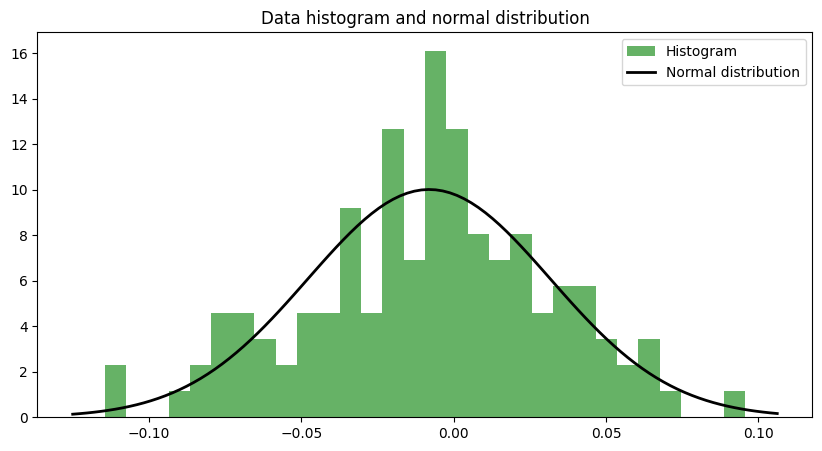

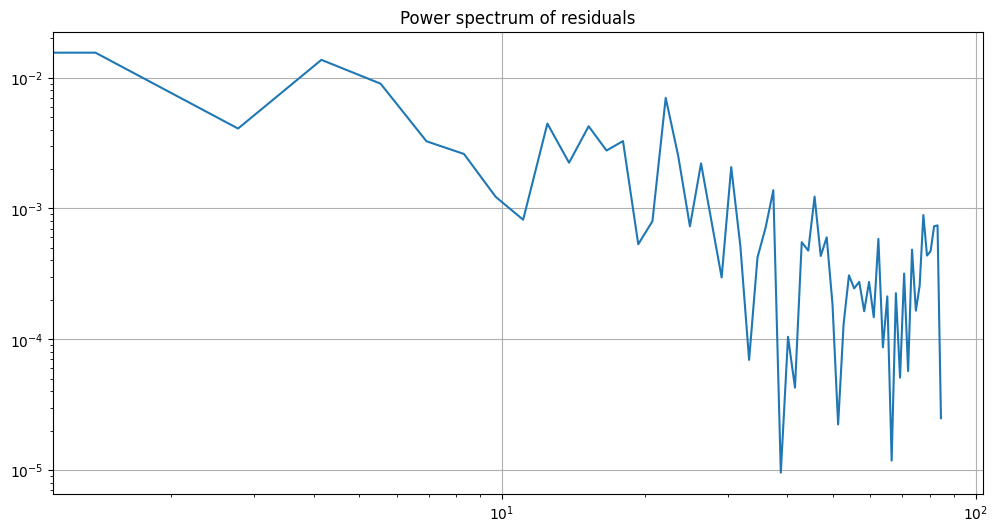

In [38]:
get_quality(y_test, y_pred, test, show_stat=True)

Here we compute SHAP values to get the features importance

In [39]:
explainer = shap.TreeExplainer(model)

explanations = explainer(x_train)

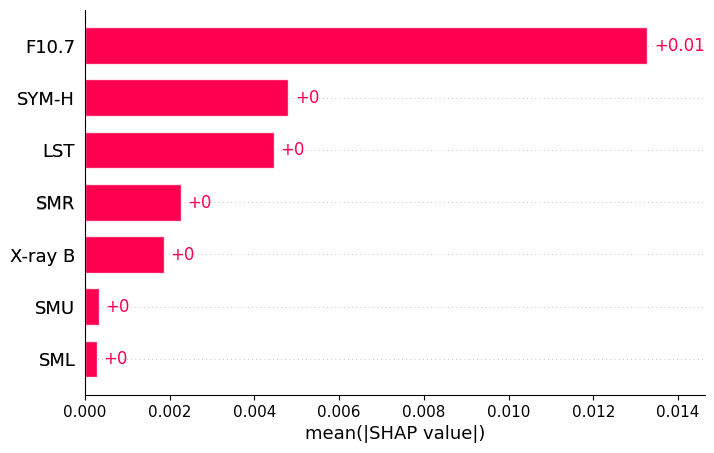

In [40]:
shap.plots.bar(explanations)

### Gaussian Process

In [41]:
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel,
        random_state=0)
model.fit(x_train, y_train)
print(model.score(x_train, y_train))

0.337510548712741


In [42]:
y_pred = np.ravel(model.predict(x_test))
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 0.009781096665913869


Mean absolute error between series: 0.0402772248003165


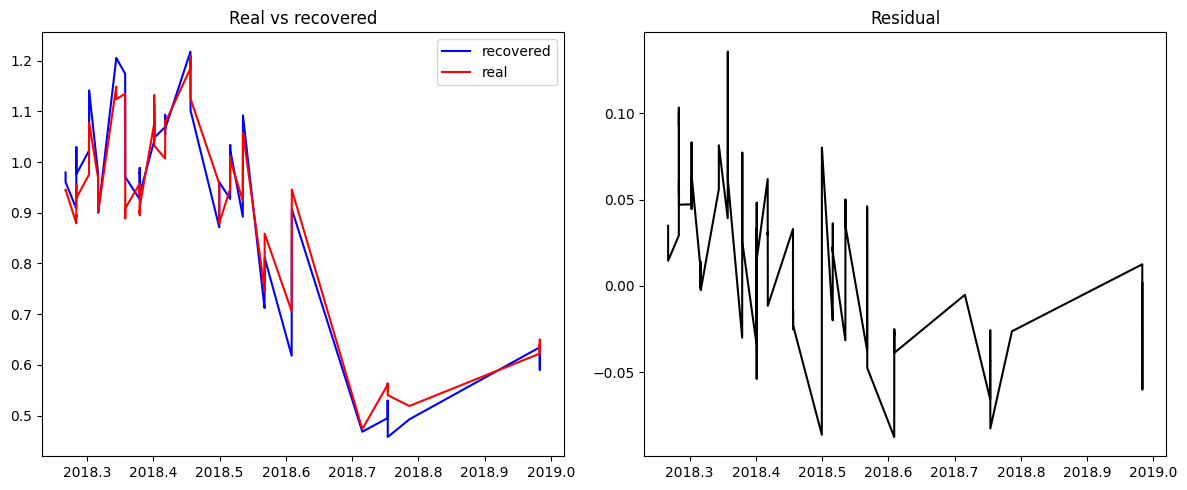

In [43]:
get_quality(y_test, y_pred, test)